In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score
import random
import time
import os
from datetime import datetime
import tensorflow as tf
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
# import tensorflow_addons as tfa
from tensorflow_addons.seq2seq import BeamSearchDecoder



from dataloader import SeqDataLoader
import argparse


c:\Users\anshm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Cell 2
def batch_data(x, y, batch_size):
    shuffle = np.random.permutation(len(x))
    start = 0
    x = x[shuffle]
    y = y[shuffle]
    while start + batch_size <= len(x):
        yield x[start:start+batch_size], y[start:start+batch_size]
        start += batch_size


In [5]:
# Cell 3
def flatten(name, input_var):
    dim = 1
    for d in input_var.get_shape()[1:].as_list():
        dim *= d
    output_var = tf.reshape(input_var,
                            shape=[-1, dim],
                            name=name)
    return output_var


In [6]:
# Cell 4
def build_firstPart_model(input_var, keep_prob_=0.5):
    output_conns = []

    # CNNs with small filter size at the first layer
    network = tf.layers.conv1d(inputs=input_var, filters=64, kernel_size=50, strides=6,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.max_pooling1d(inputs=network, pool_size=8, strides=8, padding='same')
    network = tf.nn.dropout(network, keep_prob_)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=8, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=8, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=8, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.max_pooling1d(inputs=network, pool_size=4, strides=4, padding='same')
    network = flatten(name="flat1", input_var=network)
    output_conns.append(network)

    # CNNs with large filter size at the first layer
    network = tf.layers.conv1d(inputs=input_var, filters=64, kernel_size=400, strides=50,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.max_pooling1d(inputs=network, pool_size=4, strides=4, padding='same')
    network = tf.nn.dropout(network, keep_prob_)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=6, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=6, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.conv1d(inputs=network, filters=128, kernel_size=6, strides=1,
                               padding='same', activation=tf.nn.relu)
    network = tf.layers.max_pooling1d(inputs=network, pool_size=2, strides=2, padding='same')
    network = flatten(name="flat2", input_var=network)
    output_conns.append(network)

    # Concat
    network = tf.concat(output_conns, 1, name="concat1")
    network = tf.nn.dropout(network, keep_prob_)

    return network


In [7]:
# Cell 5
def plot_attention(attention_map, input_tags=None, output_tags=None):
    attn_len = len(attention_map)
    plt.clf()
    f = plt.figure(figsize=(15, 10))
    ax = f.add_subplot(1, 1, 1)
    i = ax.imshow(attention_map, interpolation='nearest', cmap='gray')
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)
    ax.set_yticks(range(attn_len))
    if output_tags is not None:
        ax.set_yticklabels(output_tags[:attn_len])
    ax.set_xticks(range(attn_len))
    if input_tags is not None:
        ax.set_xticklabels(input_tags[:attn_len], rotation=45)
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    ax.grid()
    HERE = os.path.realpath(os.path.join(os.path.realpath(__file__), '..'))
    dir_save = os.path.join(HERE, 'attention_maps')
    if not os.path.exists(dir_save):
        os.mkdir(dir_save)
    f.savefig(os.path.join(dir_save, 'a_map_1.pdf'), bbox_inches='tight')
    plt.show()


In [8]:
# Cell 6
def build_network(hparams, char2numY, inputs, dec_inputs, keep_prob_=0.5):
    if hparams.akara2017 is True:
        _inputs = tf.reshape(inputs, [-1, hparams.input_depth, 1])
        network = build_firstPart_model(_inputs, keep_prob_)
        shape = network.get_shape().as_list()
        data_input_embed = tf.reshape(network, (-1, hparams.max_time_step, shape[1]))
    else:
        _inputs = tf.reshape(inputs, [-1, hparams.n_channels, hparams.input_depth // hparams.n_channels])
        conv1 = tf.layers.conv1d(inputs=_inputs, filters=32, kernel_size=2, strides=1,
                                 padding='same', activation=tf.nn.relu)
        max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
        conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1,
                                 padding='same', activation=tf.nn.relu)
        max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
        conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1,
                                 padding='same', activation=tf.nn.relu)
        max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
        shape = max_pool_3.get_shape().as_list()
        data_input_embed = tf.reshape(max_pool_3, (-1, hparams.max_time_step, shape[1] * shape[2]))

    with tf.variable_scope("embeddin") as embedding_scope:
        decoder_embedding = tf.Variable(tf.random_uniform((len(char2numY), hparams.embed_size), -1.0, 1.0), name='dec_embedding')
        decoder_emb_inputs = tf.nn.embedding_lookup(decoder_embedding, dec_inputs)

    with tf.variable_scope("encoding") as encoding_scope:
        if not hparams.bidirectional:
            def lstm_cell():
                return tf.contrib.rnn.LSTMCell(hparams.num_units)
            encoder_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(hparams.lstm_layers)])
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, inputs=data_input_embed, dtype=tf.float32)
        else:
            def lstm_cell():
                return tf.contrib.rnn.LSTMCell(hparams.num_units)
            stacked_cell_fw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(hparams.lstm_layers)], state_is_tuple=True)
            stacked_cell_bw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(hparams.lstm_layers)], state_is_tuple=True)
            ((enc_fw_out, enc_bw_out), (enc_fw_final, enc_bw_final)) = tf.nn.bidirectional_dynamic_rnn(
                cell_fw=stacked_cell_fw,
                cell_bw=stacked_cell_bw,
                inputs=data_input_embed,
                dtype=tf.float32)
            encoder_final_state = []
            for layer in range(hparams.lstm_layers):
                enc_fin_c = tf.concat((enc_fw_final[layer].c, enc_bw_final[layer].c), 1)
                enc_fin_h = tf.concat((enc_fw_final[layer].h, enc_bw_final[layer].h), 1)
                encoder_final_state.append(tf.contrib.rnn.LSTMStateTuple(c=enc_fin_c, h=enc_fin_h))
            encoder_state = tuple(encoder_final_state)
            encoder_outputs = tf.concat((enc_fw_out, enc_bw_out), 2)

    with tf.variable_scope("decoding") as decoding_scope:
        output_layer = Dense(len(char2numY), use_bias=False)
        decoder_lengths = np.ones((hparams.batch_size), dtype=np.int32) * hparams.max_time_step
        decoder_cell = tf.contrib.rnn.LSTMCell(hparams.num_units)
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=hparams.num_units, memory=encoder_outputs)
        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
            decoder_cell, attention_mechanism, attention_layer_size=hparams.num_units)
        initial_state = decoder_cell.zero_state(dtype=tf.float32, batch_size=hparams.batch_size)
        initial_state = initial_state.clone(cell_state=encoder_state)
        helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_emb_inputs,
                                                   sequence_length=decoder_lengths,
                                                   time_major=False)
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, initial_state, output_layer)
        outputs, final_context_state, final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            decoder, impute_finished=True, maximum_iterations=hparams.max_time_step)

    return outputs, final_context_state, final_sequence_lengths


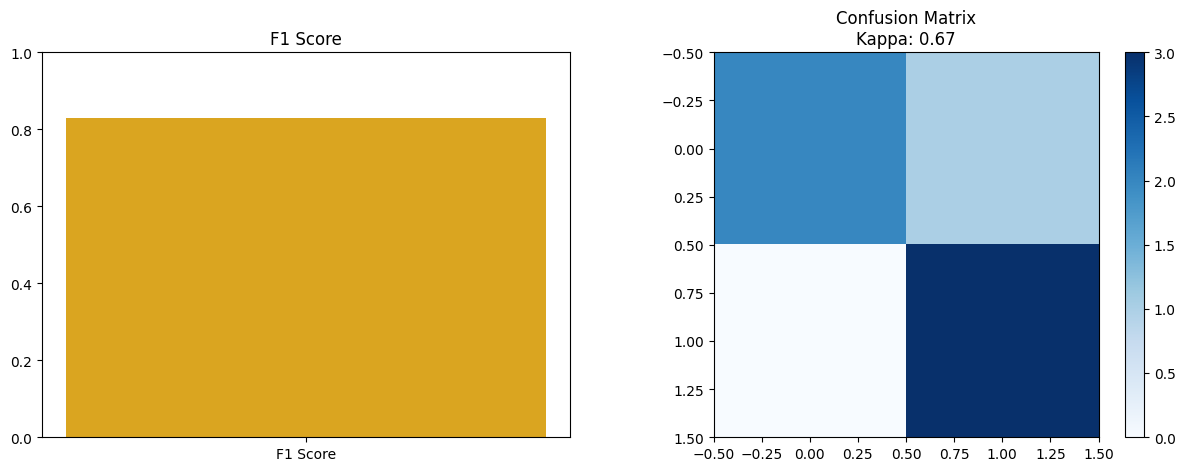

In [9]:
# Cell 7
def compute_metrics(predictions, labels):
    f1 = f1_score(labels, predictions, average='macro')
    conf_matrix = confusion_matrix(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions)
    return f1, conf_matrix, kappa

def plot_metrics(f1, kappa, conf_matrix):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].bar(['F1 Score'], [f1], color='goldenrod')
    ax[0].set_ylim([0, 1])
    ax[0].set_title('F1 Score')

    ax[1].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_title(f'Confusion Matrix\nKappa: {kappa:.2f}')
    plt.colorbar(ax[1].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues), ax=ax[1])

    plt.show()

def main():
    # Example usage
    predictions = [1, 0, 1, 1, 0, 1]  # Replace with your predictions
    labels = [1, 0, 1, 0, 0, 1]  # Replace with your labels

    f1, conf_matrix, kappa = compute_metrics(predictions, labels)
    plot_metrics(f1, kappa, conf_matrix)

if __name__ == "__main__":
    main()


In [10]:
# Cell 8
class HParams:
    def __init__(self):
        self.batch_size = 64
        self.embed_size = 128
        self.num_units = 256
        self.lstm_layers = 2
        self.max_time_step = 100
        self.input_depth = 128
        self.n_channels = 16
        self.bidirectional = True
        self.akara2017 = False

hparams = HParams()


In [11]:
# Cell 9
# Example of loading data and running a training session
def load_data():
    # Replace with actual data loading code
    pass

def train_model():
    # Example code to train model
    pass

def evaluate_model():
    # Example code to evaluate model
    pass

# Execute the pipeline
load_data()
train_model()
evaluate_model()


In [12]:
def build_whole_model(hparams, char2numY, inputs, targets, dec_inputs, keep_prob_):
    logits, pred_outputs, dec_states = build_network(hparams, char2numY, inputs, dec_inputs, keep_prob_)
    decoder_prediction = tf.argmax(logits, 2)

    # Optimization operation
    with tf.name_scope("optimization"):
        vars = tf.trainable_variables()
        beta = 0.001
        lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars if 'bias' not in v.name]) * beta

        loss_is = []
        for i in range(logits.get_shape().as_list()[-1]):
            class_fill_targets = tf.fill(tf.shape(targets), i)
            weights_i = tf.cast(tf.equal(targets, class_fill_targets), "float")
            loss_is.append(tf.contrib.seq2seq.sequence_loss(logits, targets, weights_i, average_across_batch=False))

        loss = tf.reduce_sum(loss_is, axis=0)
        loss = tf.reduce_mean(loss) + lossL2
        optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

    return logits, pred_outputs, loss, optimizer, dec_states


In [13]:
def evaluate_model(hparams, X_test, y_test, classes, sess, inputs, dec_inputs, targets, keep_prob_, pred_outputs, dec_states):
    acc_track = []
    n_classes = len(classes)
    y_true = []
    y_pred = []
    alignments_alphas_all = []

    for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_test, y_test, hparams.batch_size)):
        pred_outputs_ = sess.run(pred_outputs, feed_dict={inputs: source_batch, keep_prob_: 1.0})
        alignments_alphas = sess.run(dec_states.alignment_history.stack(), feed_dict={inputs: source_batch, dec_inputs: target_batch[:, :-1], keep_prob_: 1.0})

        pred_outputs_ = pred_outputs_[:, :hparams.max_time_step]
        target_batch_ = target_batch[:, 1:-1]
        acc_track.append(pred_outputs_ == target_batch_)

        alignments_alphas = alignments_alphas.transpose((1, 0, 2))
        alignments_alphas = alignments_alphas[:, :hparams.max_time_step]
        alignments_alphas_all.append(alignments_alphas)

        _y_true = target_batch_.flatten()
        _y_pred = pred_outputs_.flatten()

        y_true.extend(_y_true)
        y_pred.extend(_y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    ck_score = cohen_kappa_score(y_true, y_pred)
    acc_avg, acc, f1_macro, f1, sensitivity, specificity, PPV = evaluate_metrics(cm, classes)

    print(f'Average Accuracy -> {acc_avg:.4f}, Macro F1 -> {f1_macro:.4f} and Cohen\'s Kappa -> {ck_score:.4f} on test set')
    for index_ in range(n_classes):
        print(f"\t{classes[index_]} rhythm -> Sensitivity: {sensitivity[index_]:1.4f}, Specificity: {specificity[index_]:1.4f}, Precision (PPV): {PPV[index_]:1.4f}, F1 : {f1[index_]:1.4f} Accuracy: {acc[index_]:1.4f}")
    print(f"\tAverage -> Sensitivity: {np.mean(sensitivity):1.4f}, Specificity: {np.mean(specificity):1.4f}, Precision (PPV): {np.mean(PPV):1.4f}, F1-score: {np.mean(f1):1.4f}, Accuracy: {np.mean(acc):1.4f}")

    return acc_avg, f1_macro, ck_score, y_true, y_pred, alignments_alphas_all


In [14]:
def count_parameters():
    print('# of Params: ', np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

def prepare_data(hparams, FLAGS):
    num_folds = FLAGS.num_folds
    data_dir = FLAGS.data_dir
    data_version = 2013 if '13' in data_dir else 2018

    output_dir = FLAGS.output_dir
    classes = FLAGS.classes
    n_classes = len(classes)

    path, channel_ename = os.path.split(data_dir)
    traindata_dir = os.path.join(os.path.abspath(os.path.join(data_dir, os.pardir)), 'traindata/')

    char2numY = dict(zip(classes, range(len(classes))))
    char2numY['<SOD>'] = len(char2numY)
    char2numY['<EOD>'] = len(char2numY)
    num2charY = dict(zip(char2numY.values(), char2numY.keys()))

    return num_folds, data_dir, data_version, output_dir, classes, traindata_dir, char2numY, num2charY


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score
import random
import time
import os
from datetime import datetime
import tensorflow as tf
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
# import tensorflow_addons as tfa
# from tensorflow_addons.seq2seq import BeamSearchDecoder

from dataloader import SeqDataLoader
import argparse


In [21]:
def main():
    FLAGS = tf.compat.v1.flags.FLAGS

    # Define flags
    tf.compat.v1.flags.DEFINE_string('data_dir', 'data_2013/eeg_fpz_cz', """Directory where to load training data_2013.""")
    tf.compat.v1.flags.DEFINE_string('output_dir', 'outputs_2013/outputs_eeg_fpz_cz', """Directory where to save trained models and outputs.""")
    tf.compat.v1.flags.DEFINE_integer('num_folds', 20, """Number of cross-validation folds.""")
    tf.compat.v1.flags.DEFINE_list('classes', ['W', 'N1', 'N2', 'N3', 'REM'], """classes""")
    tf.compat.v1.flags.DEFINE_string('checkpoint_dir', 'checkpoints-seq2seq-sleep-EDF', """Directory to save checkpoints""")

    # Hyperparameters
    hparams = {
        'epochs': 120,
        'batch_size': 20,
        'num_units': 128,
        'embed_size': 10,
        'input_depth': 3000,
        'n_channels': 100,
        'bidirectional': False,
        'use_attention': True,
        'lstm_layers': 2,
        'attention_size': 64,
        'beam_width': 4,
        'use_beamsearch_decode': False,
        'max_time_step': 10,
        'output_max_length': 10 + 2,
        'akara2017': True,
        'test_step': 5,
    }

    num_folds, data_dir, data_version, output_dir, classes, traindata_dir, char2numY, num2charY = prepare_data(hparams, FLAGS)

    for fold_idx in range(num_folds):
        start_time_fold_i = time.time()
        data_loader = SeqDataLoader(data_dir, num_folds, fold_idx, classes=classes)
        X_train, y_train, X_test, y_test = data_loader.load_data(seq_len=hparams['max_time_step'])

        # Data processing
        # (Include data preprocessing steps here as per original code)

        # Training and testing
        if not os.path.exists(FLAGS.checkpoint_dir):
            os.mkdir(FLAGS.checkpoint_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
            inputs = tf.compat.v1.placeholder(tf.float32, [None, hparams['max_time_step'], hparams['input_depth']], name='inputs')
            targets = tf.compat.v1.placeholder(tf.int32, (None, None), 'targets')
            dec_inputs = tf.compat.v1.placeholder(tf.int32, (None, None), 'decoder_inputs')
            keep_prob_ = tf.compat.v1.placeholder(tf.float32, name='keep')

            logits, pred_outputs, loss, optimizer, dec_states = build_whole_model(hparams, char2numY, inputs, targets, dec_inputs, keep_prob_)
            count_parameters()
            sess.run(tf.compat.v1.global_variables_initializer())
            sess.run(tf.compat.v1.local_variables_initializer())
            saver = tf.compat.v1.train.Saver()

            ckpt_name = "model_fold{:02d}.ckpt".format(fold_idx)
            ckpt_exist = os.path.isfile(os.path.join(FLAGS.checkpoint_dir, ckpt_name))

            if ckpt_exist:
                saver.restore(sess, os.path.join(FLAGS.checkpoint_dir, ckpt_name))
                evaluate_model(hparams, X_test, y_test, classes, sess, inputs, dec_inputs, targets, keep_prob_, pred_outputs, dec_states)
            else:
                pre_f1_macro = 0
                for epoch_i in range(hparams['epochs']):
                    start_time = time.time()
                    y_true = []
                    y_pred = []
                    for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, hparams['batch_size'])):
                        _, batch_loss, batch_logits = sess.run([optimizer, loss, logits], feed_dict={inputs: source_batch, targets: target_batch, keep_prob_: 0.5})
                        # Print progress
                        print(f'Epoch {epoch_i+1}, Batch {batch_i+1}, Loss: {batch_loss:.4f}')

                    if epoch_i % 10 == 0:
                        acc_avg, f1_macro, ck_score, y_true, y_pred, alignments_alphas_all = evaluate_model(hparams, X_test, y_test, classes, sess, inputs, dec_inputs, targets, keep_prob_, pred_outputs, dec_states)

                        if f1_macro > pre_f1_macro:
                            saver.save(sess, os.path.join(FLAGS.checkpoint_dir, ckpt_name))
                            pre_f1_macro = f1_macro

                    print(f'Epoch {epoch_i+1} duration: {time.time() - start_time:.2f}s')
                    
        print(f'Fold {fold_idx} completed in {time.time() - start_time_fold_i:.2f}s')

# if __name__ == '__main__':
    # main()
